In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model
from circuits.pqc_circuits import qiskit_PQC_RZRX, qiskit_PQC_RXRZ

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data

from models.qiskit_models import SimpleQiskitQuantumModel


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)

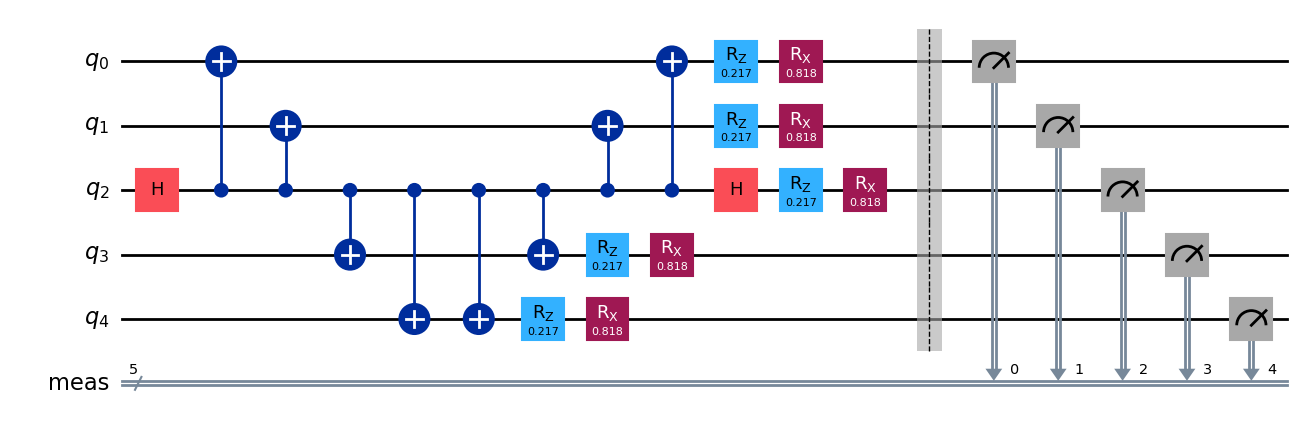

In [6]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(3)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params)
test_circ_pqc.draw('mpl')

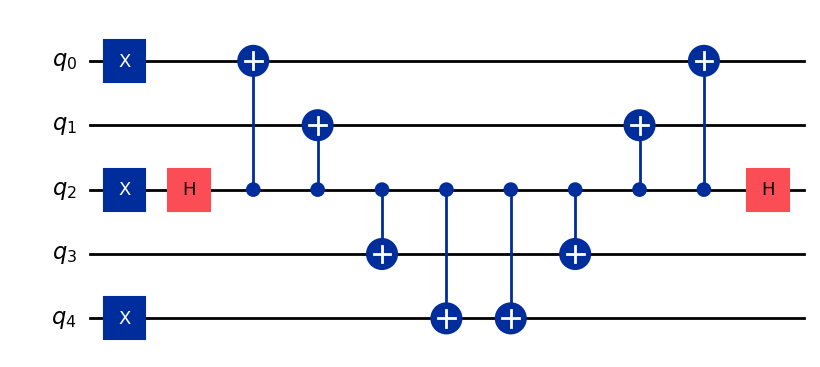

In [7]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(5,2))
mcirc.draw('mpl')

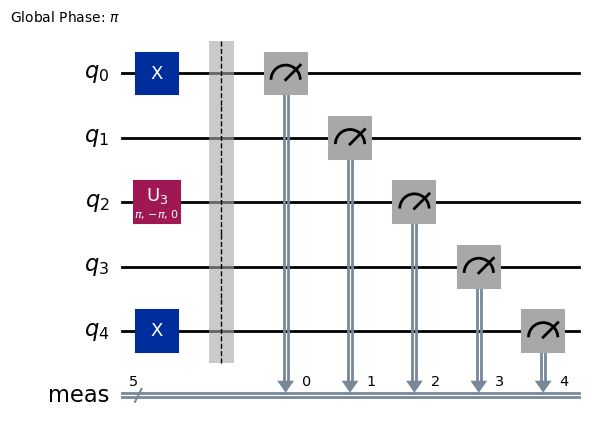

In [8]:
mcirc_measured = mcirc.measure_all(inplace=False)
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_measured, ideal_sim)
transpiled_circ.draw('mpl')

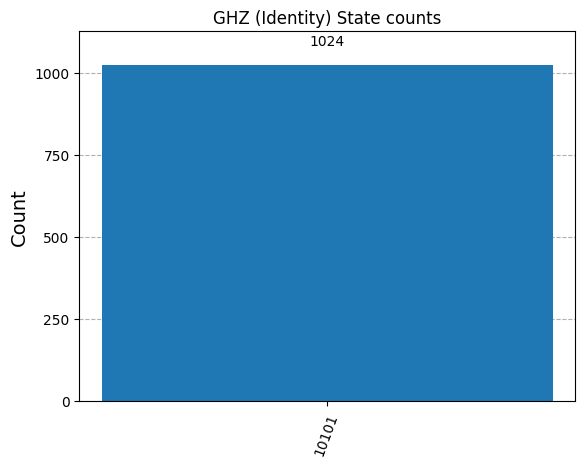

In [9]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='GHZ (Identity) State counts')

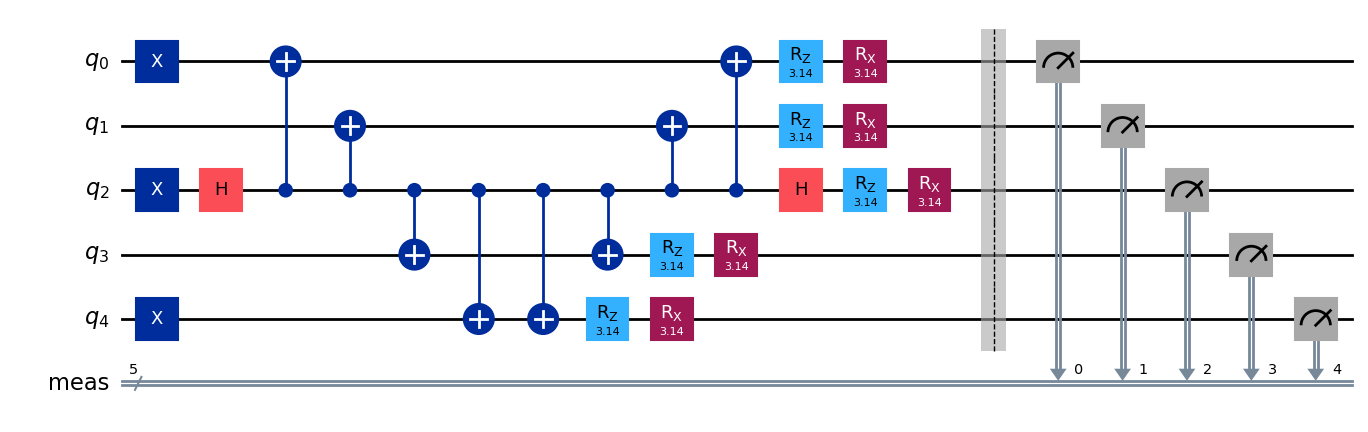

In [10]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.full((mcirc.num_qubits,), torch.pi))
mcirc_pqc.draw('mpl')

In [11]:
ideal_counts = get_ideal_shots(input=INPUT_BITS, shots=NUM_SHOTS)
measured_counts_ideal = run_circuit_sim(circuit=mcirc_pqc, simulator=ideal_sim, num_shots=NUM_SHOTS)
measured_counts_noisy = run_circuit_sim(circuit=mcirc_pqc, simulator=noisy_sim, num_shots=NUM_SHOTS)

print(ideal_counts)
print(measured_counts_ideal)
print(measured_counts_noisy)

print(torch.dist(measured_counts_ideal.float(), measured_counts_noisy.float()))

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1024.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.])
tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1024,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([  0,   0,  11,   0,   0,   0,   0,   0,  20,   0, 931,  17,   1,   0,
         28,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  13,   2,
          0,   0,   0,   0])
tensor(102.0686)


# Autorgrad Function, followed by Model

In [12]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=True)
print(len(ideal_data[10][1]))

32


In [13]:
ghz_circuit = custom_ghz(NUM_QUBITS, 2)
pqc_model = SimpleQiskitQuantumModel(num_params=2, simulator=ideal_sim, 
                                     num_shots=NUM_SHOTS, base_circuit=ghz_circuit,
                                     pqc_arch_func=qiskit_PQC_RXRZ)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.0075)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


loss_fn = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(device)

mps


In [14]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = []
    for bitstring, ideal in ideal_data:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=get_circuit_for_model(bitstring, ghz_circuit))
        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(measured, ideal)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        # print(param_list)


        if (ctr) % (len(ideal_data) // 10) == 0:
            
            print(f'Count {ctr}, Loss: {loss:.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1
Count 100, Loss: 28609.7500, Params: Parameter containing:
tensor([4.2608, 1.8927], requires_grad=True)
Count 200, Loss: 29071.3750, Params: Parameter containing:
tensor([4.2289, 1.8785], requires_grad=True)
Count 300, Loss: 32906.9375, Params: Parameter containing:
tensor([4.1973, 1.8645], requires_grad=True)
Count 400, Loss: 33944.1875, Params: Parameter containing:
tensor([4.1660, 1.8506], requires_grad=True)
Count 500, Loss: 34287.3125, Params: Parameter containing:
tensor([4.1349, 1.8368], requires_grad=True)
Count 600, Loss: 34339.6875, Params: Parameter containing:
tensor([4.1040, 1.8230], requires_grad=True)
Count 700, Loss: 30389.0625, Params: Parameter containing:
tensor([4.0733, 1.8094], requires_grad=True)
Count 800, Loss: 36438.7500, Params: Parameter containing:
tensor([4.0429, 1.7959], requires_grad=True)
Count 900, Loss: 36238.0000, Params: Parameter containing:
tensor([4.0127, 1.7825], requires_grad=True)
Count 1000, Loss: 32765.7500, Params: Parameter

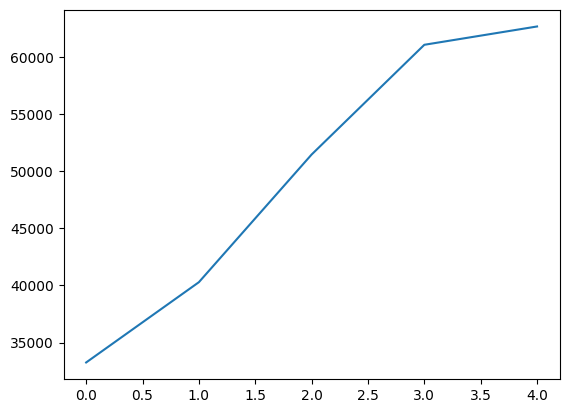

In [15]:
plt.plot([i for i in range(len(loss_list_epoch))], loss_list_epoch)
plt.show()

In [16]:
param_arr = np.array(param_list).transpose()
print(param_arr)


[[4.2925134 4.2921915 4.2918696 ... 2.9510756 2.9508543 2.950633 ]
 [1.9067829 1.9066399 1.906497  ... 1.3109013 1.3108029 1.3107047]]


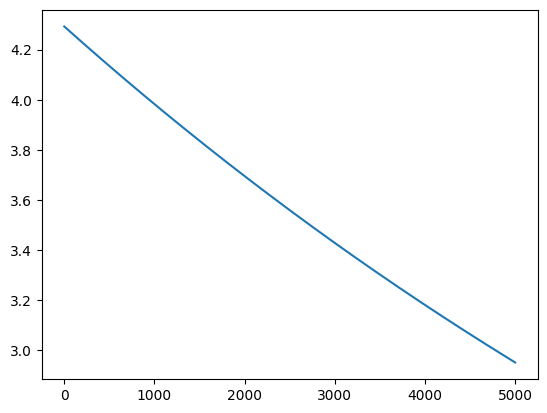

In [17]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[0])
plt.show()

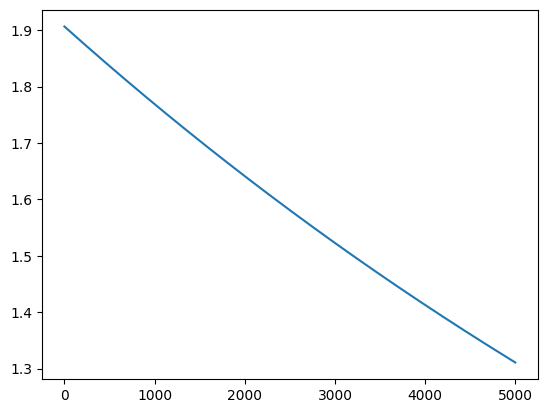

In [18]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[1])
plt.show()

In [19]:
pqc_model.pqc_params

Parameter containing:
tensor([2.9506, 1.3107], requires_grad=True)

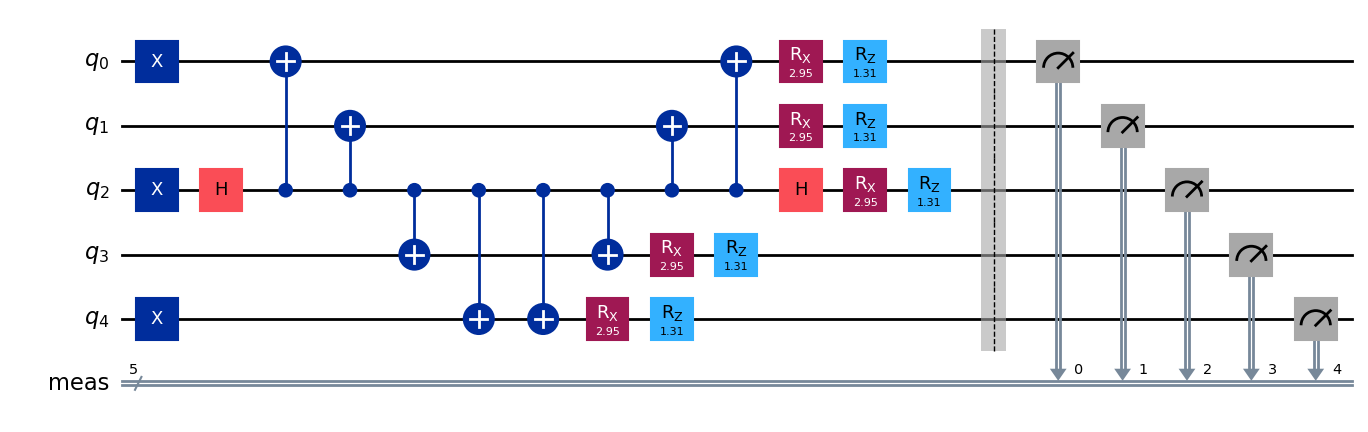

In [20]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, qiskit_PQC_RXRZ)
mcirc_post.draw('mpl')

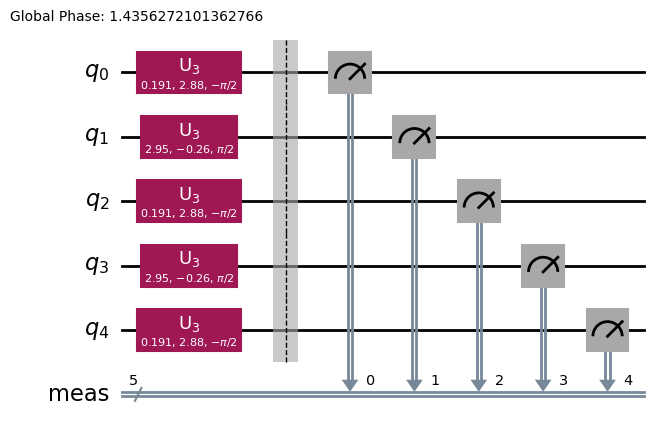

In [21]:

transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

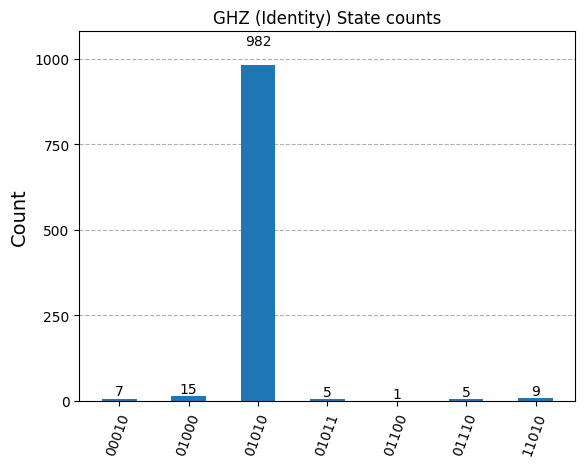

In [22]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

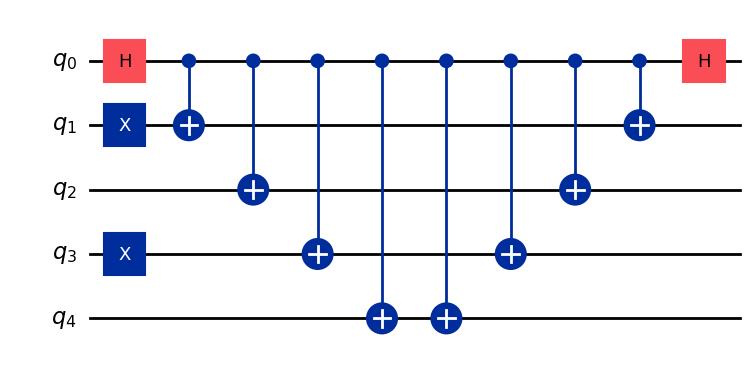

In [23]:
mcirc = get_circuit_for_model('01010', custom_ghz(5,0))
mcirc.draw('mpl')

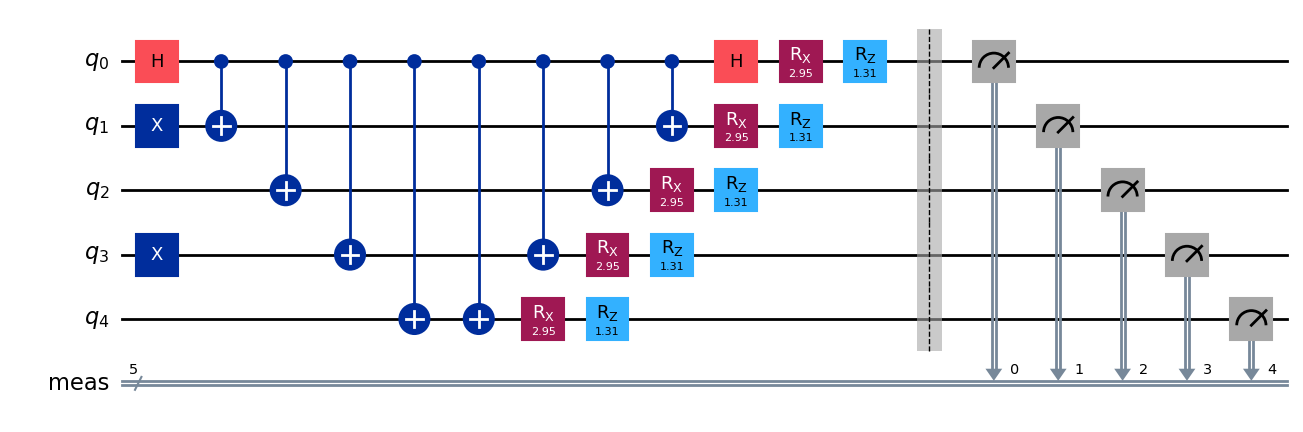

In [24]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, qiskit_PQC_RXRZ)
mcirc_post.draw('mpl')

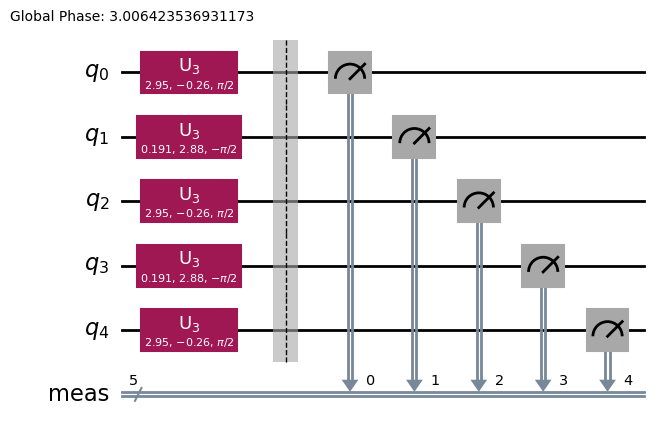

In [25]:
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

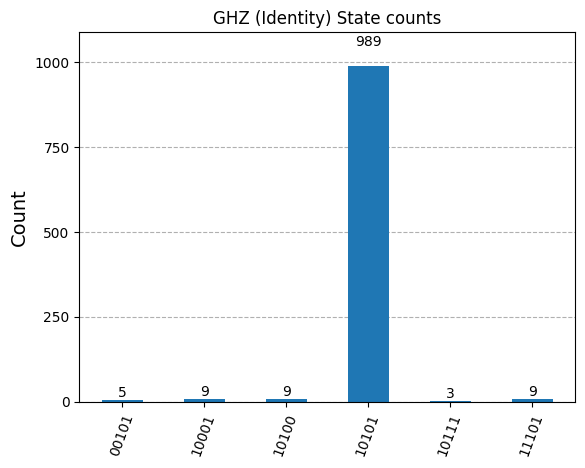

In [26]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')